# Import Libraries

In [66]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from evaluate import load

In [ ]:
!pip install rouge_score

# Import metrics BLEU,ROUGE,METEOR

In [ ]:
bleu = load("bleu") # BLEU score
rouge = load("rouge") # ROUGE score
meteor = load("meteor") # METEOR score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/emilioleo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/emilioleo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/emilioleo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load file of Prometheus Evaluation 

In [ ]:
df_eval=pd.read_csv("./outputs/prometheus_eval.csv") # Load evaluation results

# Compute metrics

In [ ]:
def compute_metrics_model(name_model,predictions,references):
    #results dictionary to store the metrics
    results = { "model": "", "BLEU": 0.0,"ROUGE":0.0,"METEOR":0.0}
    results["model"]=name_model # Name of the model

    # Compute BLEU score for each prediction-reference pair and average them
    bleu_scores = [bleu.compute(predictions=[p], references=[r])["bleu"] for p, r in zip(predictions, references)]
    results["BLEU"]=sum(bleu_scores)/len(bleu_scores)
    
    # Compute ROUGE-L score for each prediction-reference pair and average them
    rouge_scores = [rouge.compute(predictions=[p], references=[r])["rougeL"] for p, r in zip(predictions, references)]
    results["ROUGE"]=sum(rouge_scores)/len(rouge_scores)
    
    #Compute METEOR score for each prediction-reference pair and average them
    meteor_scores = [meteor.compute(predictions=[p], references=[r])["meteor"] for p, r in zip(predictions, references)]
    results["METEOR"]=sum(meteor_scores)/len(meteor_scores)

    return results

In [ ]:
# Prepare the sentences of mt5 model for each model
sentences_mt5=[]
for s in df_eval["mt5"]:
    s1= s.replace("<pad>", "").replace("[", "").replace("]", "").replace("'", "").strip() # Clean up the mt5 sentences eliminating unwanted characters
    sentences_mt5.append(s1) #  Store cleaned sentences in a list

# Prepare the models dictionary with predictions for each model
models={"mistral":df_eval["mistral"],"NLLB":df_eval["nllb"],"mt5":sentences_mt5,"tinyllama":df_eval["tinyllama"]}


list_dict=[]
for m in models:
    # Compute metrics for each model
    dict_metric=compute_metrics_model(m,models[m],df_eval["HumanEval"]) # HumanEval is the reference text
    list_dict.append(dict_metric) # Store the results in a list

# Create a DataFrame from the list of dictionaries
df_metrics=pd.DataFrame([list_dict[0],list_dict[1],list_dict[2],list_dict[3]])
df_metrics.head(5)

Dict metric model mistral: {'model': 'mistral', 'BLEU': 0.23943392683874082, 'ROUGE': np.float64(0.5470438320072561), 'METEOR': np.float64(0.5791722306444772)}
Dict metric model NLLB: {'model': 'NLLB', 'BLEU': 0.19056310783578703, 'ROUGE': np.float64(0.5293464821560969), 'METEOR': np.float64(0.5540045348070717)}
Dict metric model mt5: {'model': 'mt5', 'BLEU': 0.1264514024815673, 'ROUGE': np.float64(0.43328168925639166), 'METEOR': np.float64(0.4484292250323983)}
Dict metric model tinyllama: {'model': 'tinyllama', 'BLEU': 0.025088615249050865, 'ROUGE': np.float64(0.2844544932981795), 'METEOR': np.float64(0.30591728314692734)}


,model,BLEU,ROUGE,METEOR
0,mistral,0.239434,0.547044,0.579172
1,NLLB,0.190563,0.529346,0.554005
2,mt5,0.126451,0.433282,0.448429
3,tinyllama,0.025089,0.284454,0.305917


# Plot Histogram

In [ ]:
def plot_text(bars,axes):
    # Function to plot the text on top of the bars in the bar chart
    for bar in bars: 
        # Get the height of each bar and add text above it
        height = bar.get_height()
        # Add text annotation above each bar with the height value 
        axes.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,                
            f"{height:.3f}",          
            ha='center', va='bottom', fontsize=10
        )




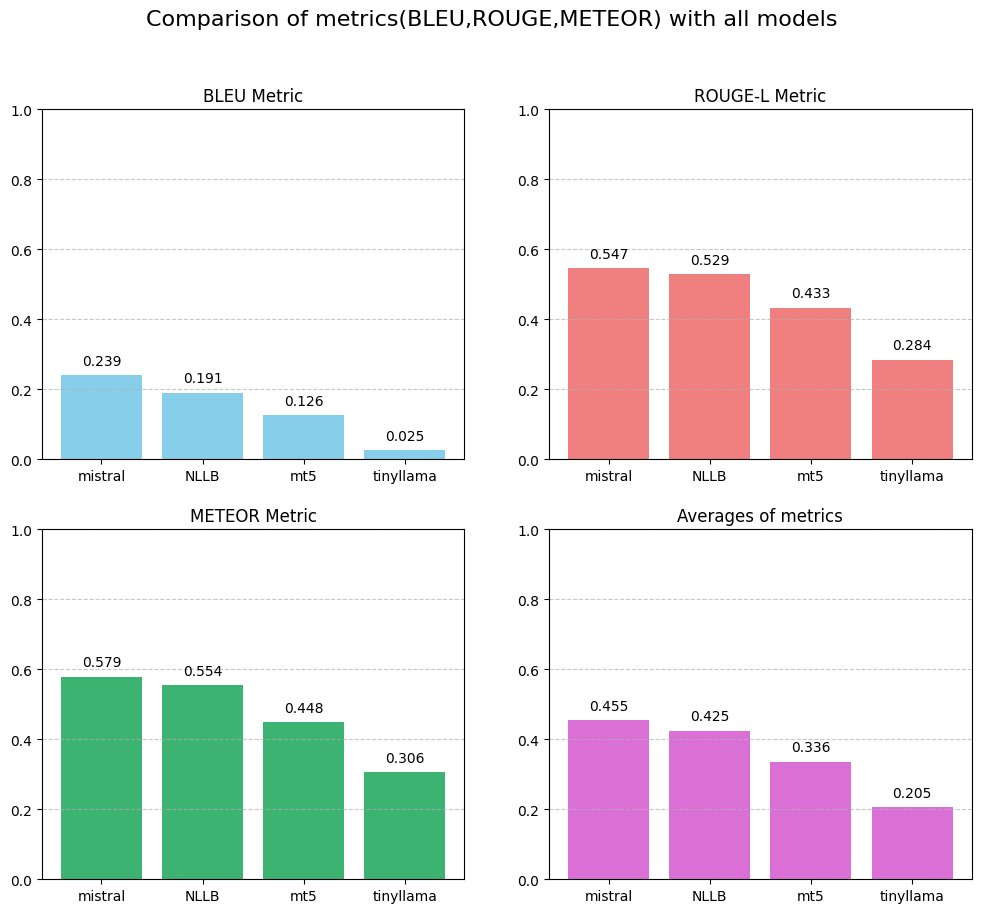

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) #    Create a 2x2 grid of subplots
fig.suptitle("Comparison of metrics(BLEU,ROUGE,METEOR) with all models", fontsize=16) # Set the title of the figure
 
# Plot BLEU in a separate subplot and add text annotations
bars_bleu=axes[0, 0].bar(df_metrics["model"],df_metrics["BLEU"], color='skyblue') 
axes[0, 0].set_title("BLEU Metric")
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
plot_text(bars_bleu,axes[0, 0])

#Plot ROUGE-L metric in the second subplot
bars_rouge=axes[0, 1].bar(df_metrics["model"],df_metrics["ROUGE"], color='lightcoral')
axes[0, 1].set_title("ROUGE-L Metric")
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
plot_text(bars_rouge,axes[0, 1])

# Plot METEOR metric in the third subplot
bars_meteor=axes[1, 0].bar(df_metrics["model"],df_metrics["METEOR"], color='mediumseagreen')
axes[1, 0].set_title("METEOR Metric")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
plot_text(bars_meteor,axes[1, 0])

#Calculate the average score across BLEU, ROUGE, and METEOR for each model
average_score=[]
for b, r, m in zip(df_metrics["BLEU"],df_metrics["ROUGE"],df_metrics["METEOR"]):
    average_score.append((b + r + m) / 3)

# Plot the average scores in the last subplot    
bars_mean=axes[1, 1].bar(df_metrics["model"], average_score, color='orchid')
axes[1, 1].set_title("Averages of metrics")
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
plot_text(bars_mean,axes[1,1])
